# Prepare data for random forest

In [1]:
import pandas as pd
import numpy as np

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sales = pd.read_csv('./input/consolidated_data.csv')
test = pd.read_csv('./input/test.csv')

In [3]:
sales.drop(columns='median_monthly_price', inplace=True)

## Reduce size for training convert all columns to float32 

In [4]:
sales = sales.astype(np.float32)

In [5]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17049984 entries, 0 to 17049983
Data columns (total 14 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   shop_id                   float32
 1   item_id                   float32
 2   date_block_num            float32
 3   month                     float32
 4   year                      float32
 5   item_cnt_month            float32
 6   months_since_sale         float32
 7   item_category_id          float32
 8   item_cnt_month - 1        float32
 9   item_cnt_month - 2        float32
 10  item_cnt_month - 3        float32
 11  median_monthly_price - 1  float32
 12  median_monthly_price - 2  float32
 13  median_monthly_price - 3  float32
dtypes: float32(14)
memory usage: 910.6 MB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB


# Random Forest

In [7]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import gc

In [8]:
def create_submission(tset, testdf, preds):
    preds = np.clip(preds,0,20)
    tset['item_cnt_month'] = preds
    sub = testdf.merge(tset, 'inner', on=['shop_id', 'item_id']).loc[:,['ID', 'item_cnt_month']]
    sub.to_csv('./submission.csv', index=False)

def fi(model, df):
    f = model.feature_importances_
    cols = df.columns
    x = pd.DataFrame({'Features': cols, 'Importance': f})
    x.sort_values(by='Importance', ascending=False, ignore_index=True, inplace=True)
    return x

def train_rf_regressor(X, y, 
                       n_estimators=100, max_samples=500000,
                       min_samples_leaf=4, oob_score=True,
                       n_jobs=-1, verbose=2, max_features=1):
    return RandomForestRegressor(n_estimators=n_estimators, 
                                 max_samples=max_samples, 
                                 min_samples_leaf=min_samples_leaf,
                                 oob_score=oob_score, n_jobs=-1, 
                                 verbose=verbose, max_features=max_features).fit(X,y)

def validate_rf_regressor(model, train_y, valid_x, valid_y):
    print(f'Out of bag score is {model.oob_score_}')
    preds = model.predict(valid_x)
    rmse_v = rmse_score(preds, valid_y)
    rmse_t = rmse_score(model.oob_prediction_, train_y)
    print(f'RMSE score on validation set is {rmse_v}')
    print(f'RMSE score on training set is {rmse_t}')
    t_predictions = np.stack([t.predict(valid_set) for t in model.estimators_])
    plt.plot([rmse_score(t_predictions[:i+1].mean(0), valid_y) for i in range(len(model.estimators_))]);
    
    
def rmse_score(preds, truth_val):
    preds = np.clip(preds, 0, 20)
    truth_val = np.clip(truth_val, 0, 20)
    return np.sqrt(mean_squared_error(truth_val, preds))


## Declare training, validation and test sets

In [9]:
test_idxs = np.where(sales.date_block_num == 34)[0]
valid_idxs = np.where(sales.date_block_num == 33)[0]
train_idxs = np.where(sales.date_block_num<=32)[0]

In [10]:
test_set = sales.loc[test_idxs]
valid_set = sales.loc[valid_idxs]
train_set = sales.loc[train_idxs]

In [11]:
valid_set

,shop_id,item_id,date_block_num,month,year,item_cnt_month,months_since_sale,item_category_id,item_cnt_month - 1,item_cnt_month - 2,item_cnt_month - 3,median_monthly_price - 1,median_monthly_price - 2,median_monthly_price - 3
30,2.0,1.0,33.0,10.0,2015.0,0.0,33.0,76.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
62,2.0,26.0,33.0,10.0,2015.0,0.0,33.0,40.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
94,2.0,30.0,33.0,10.0,2015.0,0.0,16.0,40.0,0.0,0.0,0.0,169.000000,169.000000,169.000000
126,2.0,31.0,33.0,10.0,2015.0,1.0,16.0,37.0,0.0,0.0,0.0,415.920013,415.920013,415.920013
158,2.0,32.0,33.0,10.0,2015.0,0.0,1.0,40.0,0.0,1.0,0.0,149.000000,149.000000,149.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17049854,59.0,22162.0,33.0,10.0,2015.0,0.0,1.0,40.0,0.0,1.0,0.0,349.000000,349.000000,349.000000
17049886,59.0,22163.0,33.0,10.0,2015.0,0.0,33.0,40.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
17049918,59.0,22164.0,33.0,10.0,2015.0,0.0,2.0,37.0,0.0,0.0,1.0,699.000000,699.000000,699.000000
17049950,59.0,22166.0,33.0,10.0,2015.0,0.0,33.0,54.0,0.0,0.0,0.0,0.000000,0.000000,0.000000


## Get Labels

In [12]:
train_y = train_set['item_cnt_month']
valid_y = valid_set['item_cnt_month']

In [13]:
train_set.drop(columns=['item_cnt_month'], inplace=True)
valid_set.drop(columns='item_cnt_month', inplace=True)
test_set.drop(columns=['item_cnt_month'], inplace=True)

In [14]:
train_set

,shop_id,item_id,date_block_num,month,year,months_since_sale,item_category_id,item_cnt_month - 1,item_cnt_month - 2,item_cnt_month - 3,median_monthly_price - 1,median_monthly_price - 2,median_monthly_price - 3
0,2.0,1.0,3.0,4.0,2013.0,3.0,76.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,1.0,4.0,5.0,2013.0,4.0,76.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,1.0,5.0,6.0,2013.0,5.0,76.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,1.0,6.0,7.0,2013.0,6.0,76.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.0,1.0,7.0,8.0,2013.0,7.0,76.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17049977,59.0,22167.0,28.0,5.0,2015.0,10.0,49.0,0.0,0.0,0.0,299.0,299.0,299.0
17049978,59.0,22167.0,29.0,6.0,2015.0,11.0,49.0,0.0,0.0,0.0,299.0,299.0,299.0
17049979,59.0,22167.0,30.0,7.0,2015.0,12.0,49.0,0.0,0.0,0.0,299.0,299.0,299.0
17049980,59.0,22167.0,31.0,8.0,2015.0,13.0,49.0,0.0,0.0,0.0,299.0,299.0,299.0


In [15]:
valid_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 532812 entries, 30 to 17049982
Data columns (total 13 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   shop_id                   532812 non-null  float32
 1   item_id                   532812 non-null  float32
 2   date_block_num            532812 non-null  float32
 3   month                     532812 non-null  float32
 4   year                      532812 non-null  float32
 5   months_since_sale         532812 non-null  float32
 6   item_category_id          532812 non-null  float32
 7   item_cnt_month - 1        532812 non-null  float32
 8   item_cnt_month - 2        532812 non-null  float32
 9   item_cnt_month - 3        532812 non-null  float32
 10  median_monthly_price - 1  532812 non-null  float32
 11  median_monthly_price - 2  532812 non-null  float32
 12  median_monthly_price - 3  532812 non-null  float32
dtypes: float32(13)
memory usage: 30.5 MB


In [41]:
rfr = train_rf_regressor(train_set, train_y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100building tree 13 of 100

building tree 14 of 100building tree 15 of 100

building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.3s


building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100building tree 38 of 100

building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100building tree 47 of 100

building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.3s finished


In [42]:
rfr.oob_score_

0.419053918831387

In [43]:
fi(rfr, train_set)

,Features,Importance
0,item_cnt_month - 1,0.223410
1,item_cnt_month - 3,0.221105
2,item_cnt_month - 2,0.175555
3,item_id,0.087185
4,median_monthly_price - 1,0.060706
5,item_category_id,0.052424
6,median_monthly_price - 2,0.044594
7,median_monthly_price - 3,0.039349
8,shop_id,0.028514
9,months_since_sale,0.025764


In [46]:
validate_rf_regressor(rfr, valid_set, valid_y)

Out of bag score is 0.419053918831387


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.2s


RMSE score on validation set is 0.6205672122713776


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.8s finished


In [47]:
predictions = np.stack([t.predict(valid_set) for t in rfr.estimators_])

In [48]:
rmse_score(predictions.mean(0), valid_y)

0.6205672122713776

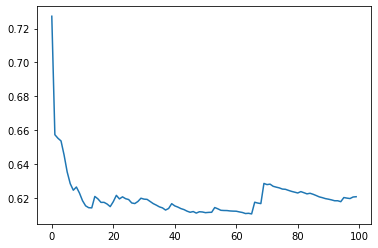

In [51]:
plt.plot([rmse_score(predictions[:i+1].mean(0), valid_y) for i in range(100)]);

In [53]:
rfr1 = train_rf_regressor(train_set, train_y, max_samples=1000000, max_features=0.5)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100

building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   34.3s


building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100building tree 40 of 100

building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.9min finished


In [54]:
fi(rfr, train_set)

,Features,Importance
0,item_cnt_month - 1,0.223410
1,item_cnt_month - 3,0.221105
2,item_cnt_month - 2,0.175555
3,item_id,0.087185
4,median_monthly_price - 1,0.060706
5,item_category_id,0.052424
6,median_monthly_price - 2,0.044594
7,median_monthly_price - 3,0.039349
8,shop_id,0.028514
9,months_since_sale,0.025764


In [55]:
validate_rf_regressor(rfr1, valid_set, valid_y)

Out of bag score is 0.5317669331686927


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.3s


RMSE score on validation set is 0.6634273774471837


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.1s finished


In [58]:
rmse_score(rfr1.oob_prediction_, train_y)

0.5872299624474138

In [59]:
predictions = np.stack([t.predict(valid_set) for t in rfr1.estimators_])

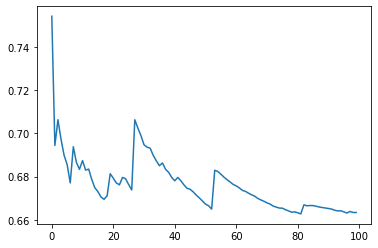

In [60]:
plt.plot([rmse_score(predictions[:i+1].mean(0), valid_y) for i in range(100)]);

In [61]:
rfr2 = train_rf_regressor(train_set, train_y, max_samples=1000000)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100building tree 13 of 100

building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100building tree 23 of 100

building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.6s


building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100building tree 46 of 100

building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   41.7s finished


Out of bag score is 0.4651117885767394


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.9s finished


RMSE score on validation set is 0.617787020570738
RMSE score on training set is 0.5964986454131689


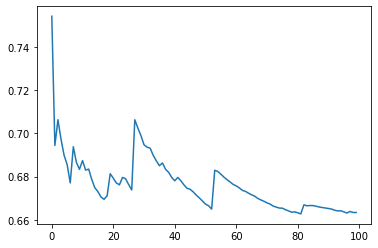

In [63]:
validate_rf_regressor(rfr2, train_y, valid_set, valid_y)

In [64]:
rfr3 = train_rf_regressor(train_set, train_y, max_samples=2000000)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100building tree 6 of 100
building tree 7 of 100

building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100building tree 13 of 100

building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100building tree 21 of 100

building tree 22 of 100
building tree 23 of 100building tree 24 of 100

building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100building tree 34 of 100



[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   21.9s


building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished


Out of bag score is 0.5201195604094873


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.9s finished


RMSE score on validation set is 0.6324437455019055
RMSE score on training set is 0.5802057408119144


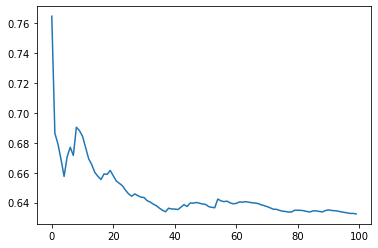

In [68]:
validate_rf_regressor(rfr3, train_y, valid_set, valid_y)

In [66]:
rfr4 = train_rf_regressor(train_set, train_y,n_estimators=200, max_samples=500000)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200building tree 21 of 200

building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.5s


building tree 34 of 200
building tree 35 of 200building tree 36 of 200

building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200building tree 61 of 200

building tree 62 of 200
building tree 63 of 200
building tree 64 of 200building tree 65 of 200

building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   29.1s


building tree 155 of 200
building tree 156 of 200
building tree 157 of 200
building tree 158 of 200
building tree 159 of 200
building tree 160 of 200
building tree 161 of 200building tree 162 of 200

building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200building tree 176 of 200

building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200building tree 194 of 200



[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   39.3s finished


Out of bag score is 0.42828685613006356


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    1.5s finished


RMSE score on validation set is 0.6040878836760952
RMSE score on training set is 0.6092059808228912


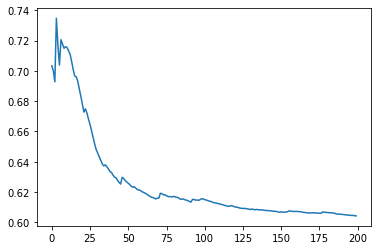

In [69]:
validate_rf_regressor(rfr4, train_y, valid_set, valid_y)

In [89]:
rfr5 = train_rf_regressor(train_set, train_y, n_estimators=300, verbose=1)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   59.6s finished


Out of bag score is 0.4229482026277781


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    2.2s finished


RMSE score on validation set is 0.6085657949244964
RMSE score on training set is 0.6082156722761273


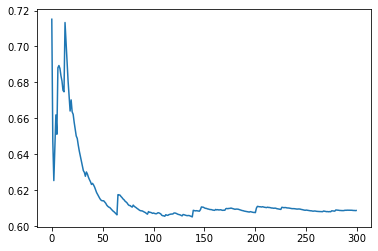

In [90]:
validate_rf_regressor(rfr5, train_y, valid_set, valid_y)

In [92]:
rfr6 = train_rf_regressor(train_set, train_y, n_estimators=150, verbose=1, min_samples_leaf=3)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   31.8s finished


Out of bag score is 0.453934888169391


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    1.1s finished


RMSE score on validation set is 0.6149737936753437
RMSE score on training set is 0.6025120736749771


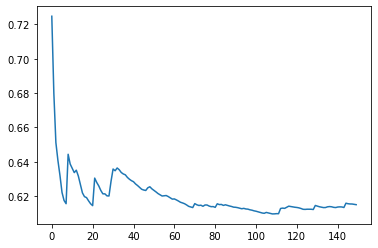

In [94]:
validate_rf_regressor(rfr6, train_y, valid_set, valid_y)

In [17]:
rfr7 = train_rf_regressor(train_set, np.clip(train_y, 0, 20), n_estimators=200, verbose=1)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   45.2s finished


Out of bag score is 0.4445275544191132


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    1.7s finished


RMSE score on validation set is 0.5839932847856799
RMSE score on training set is 0.6171798891510786


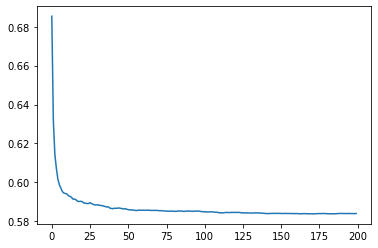

In [20]:
validate_rf_regressor(rfr7, train_y, valid_set, valid_y)

In [28]:
fi(rfr7, train_set)

,Features,Importance
0,item_cnt_month - 1,0.266350
1,item_cnt_month - 2,0.144834
2,item_id,0.103802
3,item_cnt_month - 3,0.101948
4,months_since_sale,0.082138
5,median_monthly_price - 1,0.062115
6,item_category_id,0.061819
7,shop_id,0.047587
8,median_monthly_price - 2,0.042175
9,median_monthly_price - 3,0.033942


## Train Model to make submission

In [21]:
test_idxs = np.where(sales.date_block_num == 34)[0]
train_idxs = np.where(sales.date_block_num<=33)[0]

In [22]:
test_set = sales.loc[test_idxs]
train_set = sales.loc[train_idxs]

In [23]:
train_set

,shop_id,item_id,date_block_num,month,year,item_cnt_month,months_since_sale,item_category_id,item_cnt_month - 1,item_cnt_month - 2,item_cnt_month - 3,median_monthly_price - 1,median_monthly_price - 2,median_monthly_price - 3
0,2.0,1.0,3.0,4.0,2013.0,0.0,3.0,76.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,1.0,4.0,5.0,2013.0,0.0,4.0,76.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,1.0,5.0,6.0,2013.0,0.0,5.0,76.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,1.0,6.0,7.0,2013.0,0.0,6.0,76.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.0,1.0,7.0,8.0,2013.0,0.0,7.0,76.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17049978,59.0,22167.0,29.0,6.0,2015.0,0.0,11.0,49.0,0.0,0.0,0.0,299.0,299.0,299.0
17049979,59.0,22167.0,30.0,7.0,2015.0,0.0,12.0,49.0,0.0,0.0,0.0,299.0,299.0,299.0
17049980,59.0,22167.0,31.0,8.0,2015.0,0.0,13.0,49.0,0.0,0.0,0.0,299.0,299.0,299.0
17049981,59.0,22167.0,32.0,9.0,2015.0,0.0,14.0,49.0,0.0,0.0,0.0,299.0,299.0,299.0


In [24]:
train_y = train_set['item_cnt_month']

In [25]:
train_set.drop(columns=['item_cnt_month'], inplace=True)
test_set.drop(columns=['item_cnt_month'], inplace=True)

In [26]:
rf_sub = train_rf_regressor(train_set, np.clip(train_y, 0, 20), n_estimators=200, verbose=1, oob_score=False)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   41.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   45.3s finished


In [29]:
fi(rf_sub, train_set)

,Features,Importance
0,item_cnt_month - 1,0.283088
1,item_cnt_month - 2,0.131570
2,item_cnt_month - 3,0.109619
3,item_id,0.101604
4,months_since_sale,0.077674
5,median_monthly_price - 1,0.061118
6,item_category_id,0.060131
7,shop_id,0.047448
8,median_monthly_price - 2,0.040232
9,median_monthly_price - 3,0.033921


In [27]:
create_submission(test_set, test, rf_sub.predict(test_set))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    1.7s finished
